In [37]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time


# 1. Data Analysis and Data Prepropcessing

In [38]:
df = pd.read_csv('train_data.csv') # change the file path according to your own code
df_test = pd.read_csv('test_data.csv')

## 1.1 Analyze the data


## df.describe()

In [39]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


## 1.2 Extract the Training feature X and ground-truth label Y

In [40]:
# .values is needed here to transfer a Pandas Series into numpy array

X_train_unnorm=df[['X1 transaction date','X2 house age','X3 distance to the nearest MRT station','X4 number of convenience stores','X5 latitude','X6 longitude']].values
X_test_unnorm = df_test[['X1 transaction date','X2 house age','X3 distance to the nearest MRT station','X4 number of convenience stores','X5 latitude','X6 longitude']].values


y_train=df['Y house price of unit area'].values
y_test = df_test['Y house price of unit area'].values

print('there are {} of samples in training data'.format(len(y_train)))
print('there are {} of samples in  test data'.format(len(y_test)))

there are 331 of samples in training data
there are 83 of samples in  test data


## 1.3 Standardize the data

In [41]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train_unnorm)
X_test = standard_scaler.transform(X_test_unnorm)

## 1.4 Augment the Data

In [42]:
'''
Augment the data for both X_train and X_test
'''
X_train = np.insert(X_train, 0, 1, axis=1)   #axis=1 => column_wise inserti 1 at 0th position. #numpy.insert(array, object, values, axis = None)
X_test = np.insert(X_test, 0, 1, axis=1)



# 2. Problem Solving

## 2.1 Moore-Penrose pseudoinverse Calculation

# Ideal linear regression results

1. first calculate the weight vector by using Moore Penrose Pseudoinverse

2. Code the mean square error (MSE) cost and MAPE value

3. calcuulation MSE and MAPE for both train and test data based on the learned weight and bias

In [43]:
import time
start_time = time.time()
####################################
########### Your code here #########
####################################
data = np.dot(X_train.T, X_train)
inverse = np.linalg.pinv(data)
X_del = np.dot(inverse, X_train.T)   #formula X_del = (X.T*X)-1 * X.T 
#print(X_del)
end_time = time.time()
print('calculating the Moore Penrose pseudoinverse need {} seconds'.format(end_time-start_time))
weights = np.dot(X_del, y_train)
print(weights)
data_dimension = X_train.shape[1]


calculating the Moore Penrose pseudoinverse need 0.0011670589447021484 seconds
[37.89607251  1.43395793 -3.2216376  -5.24080881  3.43446924  3.12296536
 -0.11837833]


In [44]:
MSE_cost_train = 0.0
MAPE_train = 0.0

MSE_cost_test = 0.0
MAPE_test = 0.0

def mse_cost(X,y,w):
    cost = 0.0
    """
    Compute mean square loss function
     Args:
      X (ndarray (N,D+1)): augmented data, m samples and each sample has dimension D+1
      y (ndarray (N,)) :   ground-truth label y
      w (ndarray (D+1,)) : obj1 parameters

    Returns:
      cost (scalar): cost
    """
    num = len(y)
    diff = np.dot(X, w) - y
    cost = np.dot(diff.T, diff) / num     # J(w) = 1/N * (XW-y)^T * (XW-y)
    return cost



In [45]:
def MAPE_value(X, y, w):
    y_hat = np.dot(X, w)  # Predicted values
    errors = np.abs((y - y_hat) / y)  # Element-wise absolute percentage errors
    errors = np.where(y != 0, errors, 0)  # Avoid division by zero by masking zeros in y
    mape = 100 * np.mean(errors)  # Mean Absolute Percentage Error
    return mape



MAPE_train = MAPE_value(X_train,y_train,weights)
MSE_cost_train = mse_cost(X_train, y_train, weights)
print('training mse cost is {}'.format(MSE_cost_train))
print('training MAPE value is {}'.format(MAPE_train))

MAPE_test = MAPE_value(X_test,y_test,weights)
MSE_cost_test = mse_cost(X_test,y_test,weights)
print('test mse cost is {}'.format(MSE_cost_test))
print('test MAPE value is {}'.format(MAPE_test))

training mse cost is 81.71564408352145
training MAPE value is 19.180185460603706
test mse cost is 59.40924577639813
test MAPE value is 15.77407220126113


## 2.2 Gradient descent (implements minibatch gradient descent variant2 for linear regression)

In [46]:
class MultiVariate_Linear_Regression():
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.w = np.zeros(X_train.shape[1])

    def mse_mape_cost(self, X, y, w):
        y_hat = np.dot(X, w)
        #print("check for weight value in test data calls", w)
        #print("y_hat in mse_mape_cost is" ,y_hat)
        mse_loss = np.mean((y - y_hat) ** 2)
        #print("check for mse loss for test data calls,", mse_loss)
        mape = np.mean(np.abs((y - y_hat) / y)) * 100
        return mse_loss, mape

    def _compute_gradient_per_sample(self,x,y):
        batch_size = len(y)
        #print(batch size)
        gradient = np.dot(x.T, np.dot(x, self.w) - y) / batch_size    #(Nb = batch size) #not considering multiplication by 2
        return gradient
        

    def fit_train(self, eta, epochs=40, batch_size=20):
        start_time = time.time()
        mse_hist = []
        mape_hist = []
        epoch_for_mse_below_85 = None
        time_for_mse_below_85 = None

        for epoch in range(epochs):
            data = np.concatenate((X_train, np.expand_dims(y_train, axis=1)), axis=1) 
            data = np.random.permutation(data)   #shuffle whole dataset   #np.shuffle can be used alternatively
            for i in range(0, self.X_train.shape[0], batch_size):
                end = i + batch_size
                X_batch = data[i:end, :-1]  # Assuming the last column is y   #extracting X and y from the shuffled dataset
                y_batch = data[i:end, -1] 
                gradient = self._compute_gradient_per_sample(X_batch, y_batch)
                self.w -= eta * gradient   #updated weight

            mse_loss, mape = self.mse_mape_cost(self.X_train, self.y_train, self.w)
            mse_hist.append(mse_loss)
            mape_hist.append(mape)

            if mse_loss < 85 and epoch_for_mse_below_85 is None:
                epoch_for_mse_below_85 = epoch + 1
                time_for_mse_below_85 = time.time() - start_time
                
        if epoch_for_mse_below_85 == None:
            print("MSE didn't go below 85 even in 40 epochs")
        total_time = time.time() - start_time
        return mse_hist, mape_hist, self.w, total_time, epoch_for_mse_below_85, time_for_mse_below_85

    def predict(self, X, w):
        return np.dot(X, w)


## 2.2.3 Plot the training curve about the MSE cost and MAPE

Training with η = 0.001
MSE didn't go below 85 even in 40 epochs


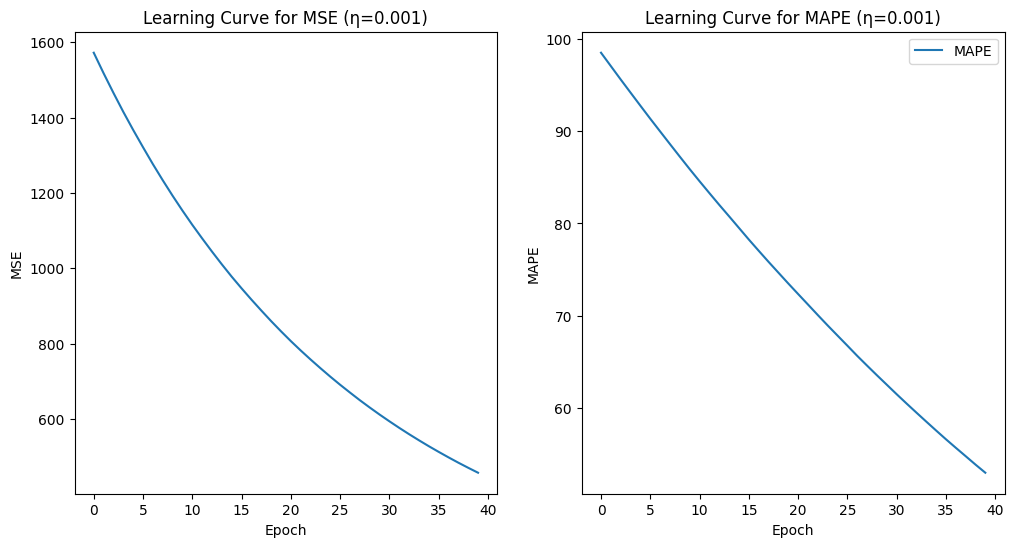

Training with η = 0.005


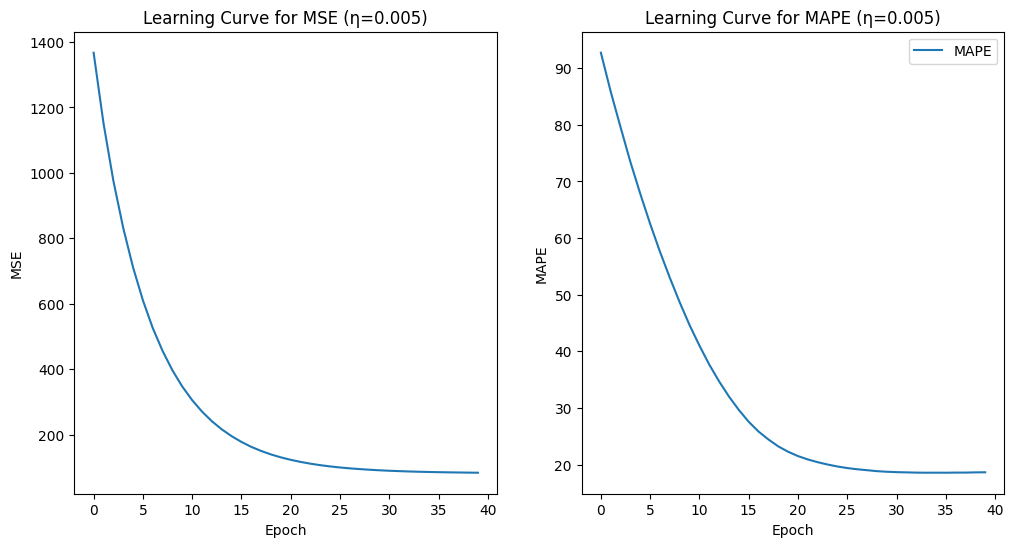

Training with η = 0.01


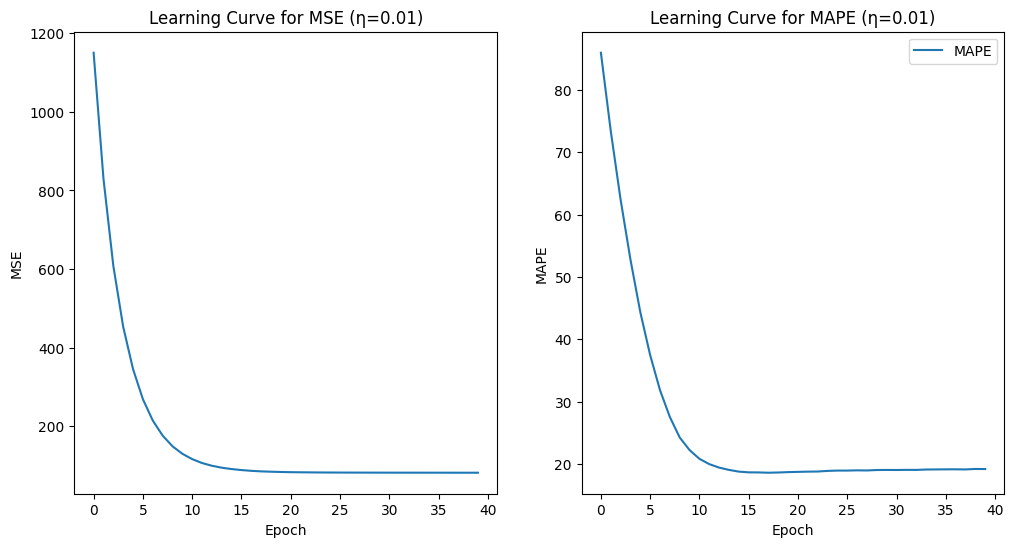

Training with η = 0.1


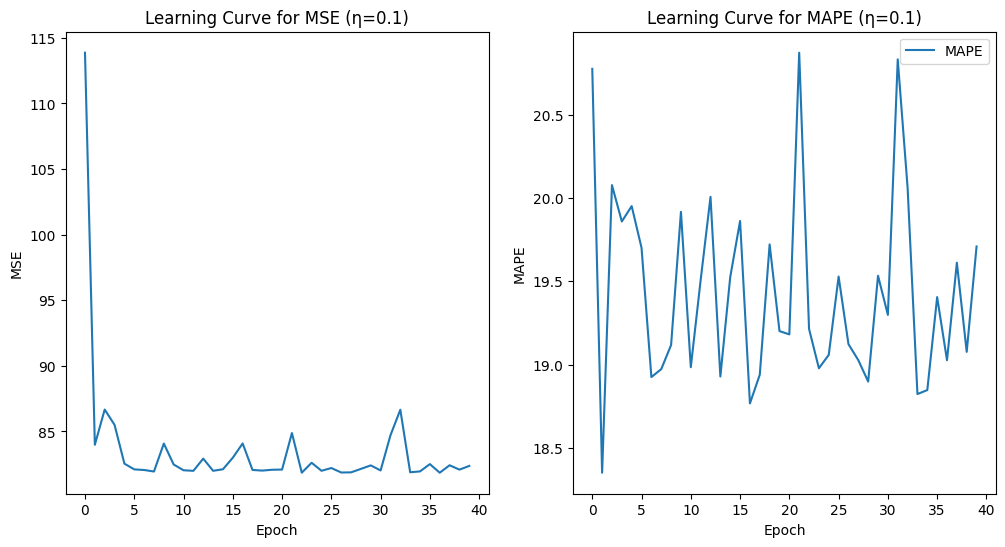

Training with η = 1
MSE didn't go below 85 even in 40 epochs


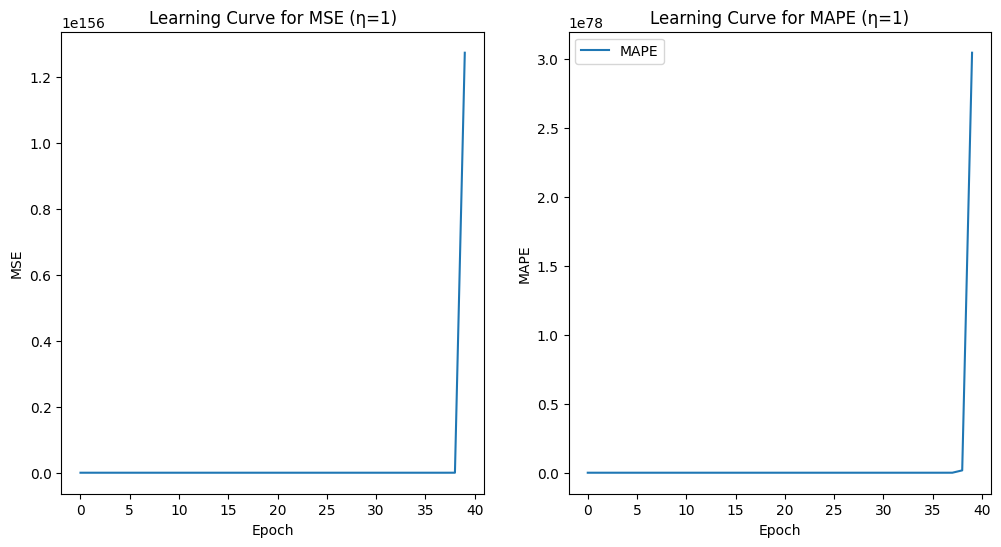

In [47]:
learning_rates = [10**-3, 5*10**-3, 10**-2, 10**-1, 10**-0]
results = {}

for eta in learning_rates:
    print(f"Training with η = {eta}")
    obj1 = MultiVariate_Linear_Regression(X_train, y_train)
    mse_hist, mape_hist, w, total_time, epoch_for_mse_below_85, time_for_mse_below_85 = obj1.fit_train(eta, epochs=40)
    #print(mse_hist)
    # Plot learning curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(mse_hist, label='MSE')
    plt.title(f'Learning Curve for MSE (η={eta})')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(mape_hist, label='MAPE')
    plt.title(f'Learning Curve for MAPE (η={eta})')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()
    
    # Store results for reporting
    results[eta] = {
        'w': w,
        'final_mse': mse_hist[-1],
        'final_mape': mape_hist[-1],
        'epoch_for_mse_below_85': epoch_for_mse_below_85,
        'total_time': total_time,
        'time_for_mse_below_85': time_for_mse_below_85}


# 3. Prediction

In [48]:
mse_test_hist = []
mape_test_hist = []

for eta, result in results.items():
    print(f"\nResults for η = {eta}:")
    print(f"- Final weight vector w: {result['w']}")
    print(f"- Final MSE (Training): {result['final_mse']}")
    print(f"- Final MAPE (Training): {result['final_mape']}%")
    y_pred = obj1.predict(X_test,result['w'])   ###***
    #print("y_pred", y_pred)
    mse_test, mape_test = obj1.mse_mape_cost(X_test, y_test, result['w'])
    print("mse test is", mse_test)
    #mse_loss, mape = self.mse_mape_cost(self.X_train, self.y_train)
    mse_test_hist.append(mse_test)
    mape_test_hist.append(mape_test)
    print(f"- MSE (Test): {mse_test_hist[-1]}")
    print(f"- MAPE (Test): {mape_test_hist[-1]}%")
    print(f"- Epochs to reach MSE < 85 (if applicable): {result['epoch_for_mse_below_85']}")
    print(f"- Total computation time: {result['total_time']} seconds")
    if result['time_for_mse_below_85'] is not None:
        print(f"- Time to reach MSE < 85: {result['time_for_mse_below_85']} seconds")
    else:
        print("- MSE < 85 was not reached within the training period.")


Results for η = 0.001:
- Final weight vector w: [18.69687644  0.68652961 -1.56550402 -2.87449902  2.60434599  2.50597485
  1.96001994]
- Final MSE (Training): 458.2192943209752
- Final MAPE (Training): 52.9391678170007%
mse test is 437.8730341500236
- MSE (Test): 437.8730341500236
- MAPE (Test): 52.146764042895114%
- Epochs to reach MSE < 85 (if applicable): None
- Total computation time: 0.01344752311706543 seconds
- MSE < 85 was not reached within the training period.

Results for η = 0.005:
- Final weight vector w: [36.66121763  1.38789677 -3.08708571 -3.79832859  3.55103918  3.32125762
  1.16857924]
- Final MSE (Training): 83.84153412470636
- Final MAPE (Training): 18.634098426942693%
mse test is 62.19270500589926
- MSE (Test): 62.19270500589926
- MAPE (Test): 15.259269158303699%
- Epochs to reach MSE < 85 (if applicable): 38
- Total computation time: 0.011975526809692383 seconds
- Time to reach MSE < 85: 0.011455297470092773 seconds

Results for η = 0.01:
- Final weight vector w:

Ques 1. d): 



From the figures of MSE vs Epoch and MAPE vs Epoch, several observations can be made regarding the behavior of the error metrics over epochs for different learning rates (η).

- For **η = 0.001**, the plots appear to be **monotonically non-increasing**, indicating that the error consistently decreases without any increase as the number of epochs increases. This suggests that the model is learning from the data over time, with the curves asymptotically approaching a minimum as the slope of the curve decreases.

- Similarly, for **η = 0.005**, the plots are monotonically decreasing, with error consistently decreasing. However, through the MAPE plot, it can be observed that after a certain point, the value of MAPE remains constant and does not decrease any further.

- For **η = 0.01**, the plots are monotonically decreasing, reaching a low value very quickly. But once it reaches this point, the value of MAPE stays constant, indicating no further decrease.

- For **η = 0.1**, the plots reach a low value very quickly. However, after reaching the minimum, the MSE shows fluctuations instead of further decreases. The MAPE vs epoch plot demonstrates significant fluctuations, indicating that the learning rate might be too large as it is barely monotonically non-increasing.

- For **η = 1**, the MSE and MAPE are not monotonically non-increasing; instead, they increase suddenly. This behavior is not desirable as it indicates that the learning rate is excessively high, leading to poor model performance.

Overall, almost all the plots are monotonically non-increasing except for η = 1, where the MSE and MAPE suddenly shoot up and remain elevated, which is indicative of suboptimal learning.

**Comparative Insights**:
- **Speed of Decrease**: Yes, some curves decrease faster than others, depending on the learning rate. As the learning rate increases, the speed at which the error metrics decrease also changes, with some learning rates leading to quicker convergence to a minimum error value.
- **Apparent Minimum Values**: The apparent minimum values of the error metrics do not necessarily improve with higher learning rates. In some cases, increasing the learning rate too much leads to instability in learning, as evidenced by fluctuating error metrics or sudden ifferent learning rates.?

Based on the provided results, here's a comparison across different learning rates (η):

### Weight Vector \( w \):
- **For η = 0.001:** The weights are relatively small and seem to be the starting values of the learning process.
- **For η = 0.005 and η = 0.01:** The weights are becoming larger but still remain within a reasonable range.
- **For η = 0.1:** The weights continue to grow, especially the second term.
- **For η = 1:** The weights have become extremely 4} \), indicating that the learning process has diverged.

### MSE (Mean Squared Error):
- **For η = 0.001:** The final MSE is quite high at 457.93, suggesting underfitting or insufficient learning.
- **For η = 0.005 and η = 0.01:** There is a significant drop in MSE to 83.87 and 81.91, respectively, indicating better learning.
- **For η = 0.1:** MSE is slightly higher at 82.59 compared to η = 0.01, which might suggest the learning rate is getting too high.
- **For η = 1:** MSE is astronomical, suggesting that the learning rate is too high, causing the model to diverge completely.

### MAPE (Mean Absolute Percentage Error):
- **For η = 0.001:** The final MAPE is 52.98%, indicating that the model predictions are off by over half of the actual value.
- **For η = 0.005:** MAPE drops significantly to 18.68%, showing a much better fit.
- **For η = 0.01:** MAPE slightly increases to 19.09%, which might be due to the learning rate.
- **For η = 0.1:** MAPE further increases to 19.70%, continuing the trend seen with η = 0.01.
- **For η = 1:** The MAPE is extremely large, reinforcing the conclusion that the learning rate is too high and the model has diverged.

In summary, η = 0.005 and 0.01 seem to provide the best results in terms of MSE and MAPE, with the model learning effectively without underfitting or diverging. The ideal learning rate appears to be between 0.005 and 0.01 for this particular model and dataset.
: 5.960232108182981e+85%378%868%53%44%


## Comparison for Different Learning Rates (η)

From the comparison, we can see that:

- The fastest learning rate to reach an MSE < 85 was η = 0.1, achieving it in just 2 epochs.
- The total computation times are quite similar across different η, with the slowest being η = 0.001 and η = 0.01, and the fastest being η = 1.
- The η = 1 did not manage to reduce the MSE below 85, which indicates a potential divergence in the learning process.


g)
-

### Using Pseudo Inverse for Initial Weights

- **Training MSE Cost**: 81.71564408352145
- **Training MAPE Value**: 19.1801854606ng rates.

### Gradient Descent Learning Rates Analysis

#### For η = 0.01
- **Final MSE (Training)**: 81.90838088794186
- **Final MAPE (Training)**: 19.086598052218868%

The values achieved with gradient descent are very close to those obtained using the pseudo inverse, indicating that the model is performing well with this learning rate.

#### For η = 0.001
- The model does not reach an MSE < 85, suggesting slower learning at this rate.

#### For η = 0.005
- The MSE drops below 85 in 38 epochs, indicating that the model is learning and improving over time, albeit at a moderate pace.

#### For η = 0.01
- The model achieves an MSE < 85 in just 18 epochs, showcasing faster learning and better performance compared to lower learning rates.

#### For η = 0.1
- The MSE falls below 85 in only 2 epochs, which might suggest that the learning rate is too high, leading to rapid but potentially unstable learning.

### Summary

The analysis indicates that the choice of learning rate has a significant impact on the speed and stability of the learning process. While a higher learning rate can lead to quicker convergence in terms of epochs needed to achieve a certain MSE threshold, it also raises concerns about potential overstepping and instability. The results from using the pseudo inverse provide a useful comparison, highlighting that gradient descent can achieve similar accuracy, with the efficiency of learning greatly influenced by the selectiontes in a structured and clear manner.